In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('../data/expenses.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


/tmp/ipykernel_16293/3678114121.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df_raw[df_raw['smoker'] == 'no']['charges'],


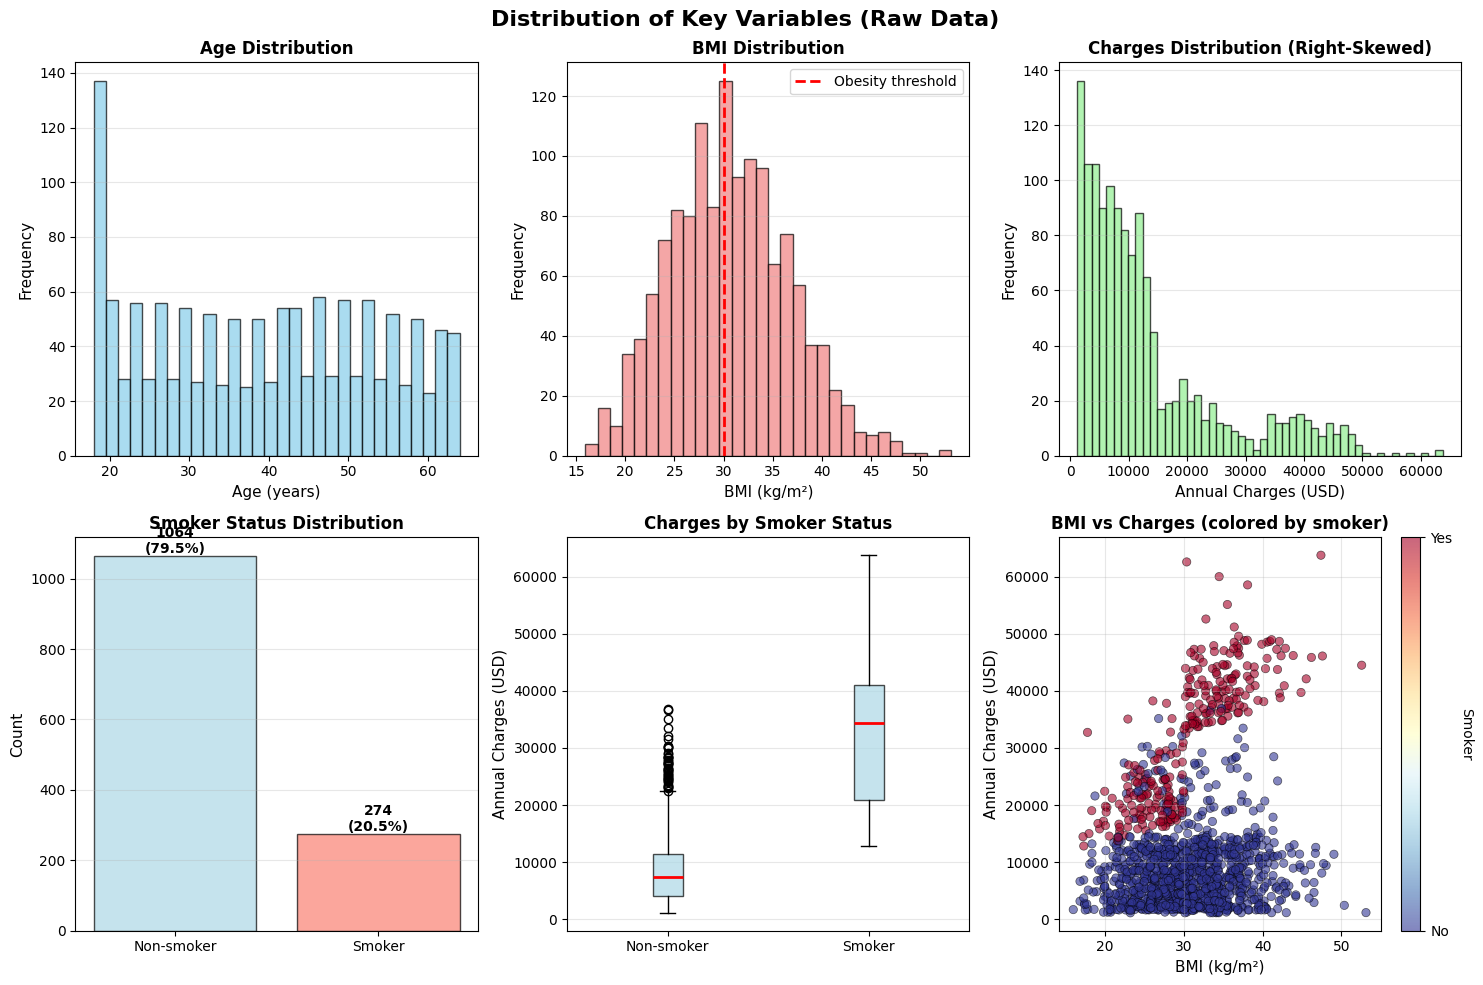

In [5]:
# Create distribution plots for key variables before standardization
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Reload raw data for visualizations
df_raw = pd.read_csv('../data/expenses.csv')

# Create output directory
output_dir = Path('outputs')
output_dir.mkdir(parents=True, exist_ok=True)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Variables (Raw Data)', fontsize=16, fontweight='bold')

# Age distribution
axes[0, 0].hist(df_raw['age'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Age (years)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Age Distribution', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# BMI distribution
axes[0, 1].hist(df_raw['bmi'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].set_xlabel('BMI (kg/m²)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('BMI Distribution', fontweight='bold')
axes[0, 1].axvline(x=30, color='red', linestyle='--', linewidth=2, label='Obesity threshold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Charges distribution (right-skewed)
axes[0, 2].hist(df_raw['charges'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].set_xlabel('Annual Charges (USD)', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title('Charges Distribution (Right-Skewed)', fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)

# Smoker status
smoker_counts = df_raw['smoker'].value_counts()
axes[1, 0].bar(['Non-smoker', 'Smoker'], 
               [smoker_counts['no'], smoker_counts['yes']], 
               color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Smoker Status Distribution', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate([smoker_counts['no'], smoker_counts['yes']]):
    axes[1, 0].text(i, v, f'{v}\n({v/len(df_raw)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Charges by smoker status (boxplot)
df_raw['smoker_label'] = df_raw['smoker'].map({'no': 'Non-smoker', 'yes': 'Smoker'})
axes[1, 1].boxplot([df_raw[df_raw['smoker'] == 'no']['charges'],
                     df_raw[df_raw['smoker'] == 'yes']['charges']],
                    labels=['Non-smoker', 'Smoker'],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_ylabel('Annual Charges (USD)', fontsize=11)
axes[1, 1].set_title('Charges by Smoker Status', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Scatter: BMI vs Charges colored by smoker
scatter = axes[1, 2].scatter(df_raw['bmi'], df_raw['charges'], 
                              c=df_raw['smoker'].map({'no': 0, 'yes': 1}),
                              cmap='RdYlBu_r', alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1, 2].set_xlabel('BMI (kg/m²)', fontsize=11)
axes[1, 2].set_ylabel('Annual Charges (USD)', fontsize=11)
axes[1, 2].set_title('BMI vs Charges (colored by smoker)', fontweight='bold')
axes[1, 2].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 2])
cbar.set_label('Smoker', rotation=270, labelpad=15)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'])

plt.tight_layout()
plt.savefig(output_dir / 'descriptive_statistics.png', dpi=300, bbox_inches='tight')
plt.show()



In [6]:
# Convert binary variables to 0/1
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

# Drop region column (not included in model to avoid hierarchical modeling)
df = df.drop('region', axis=1)

In [7]:
# Handle outliers in numerical columns
import numpy as np

numerical_cols = ['age', 'bmi', 'children', 'charges']

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

In [8]:
# Normalize/standardize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit OLS model
ols_model = LinearRegression()
# Define X and y from df
X = df.drop('charges', axis=1).values
y = df['charges'].values

# Fit OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)

# Predictions
y_pred = ols_model.predict(X)

# Model performance
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

# Predictions
y_pred = ols_model.predict(X)

# Model performance
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

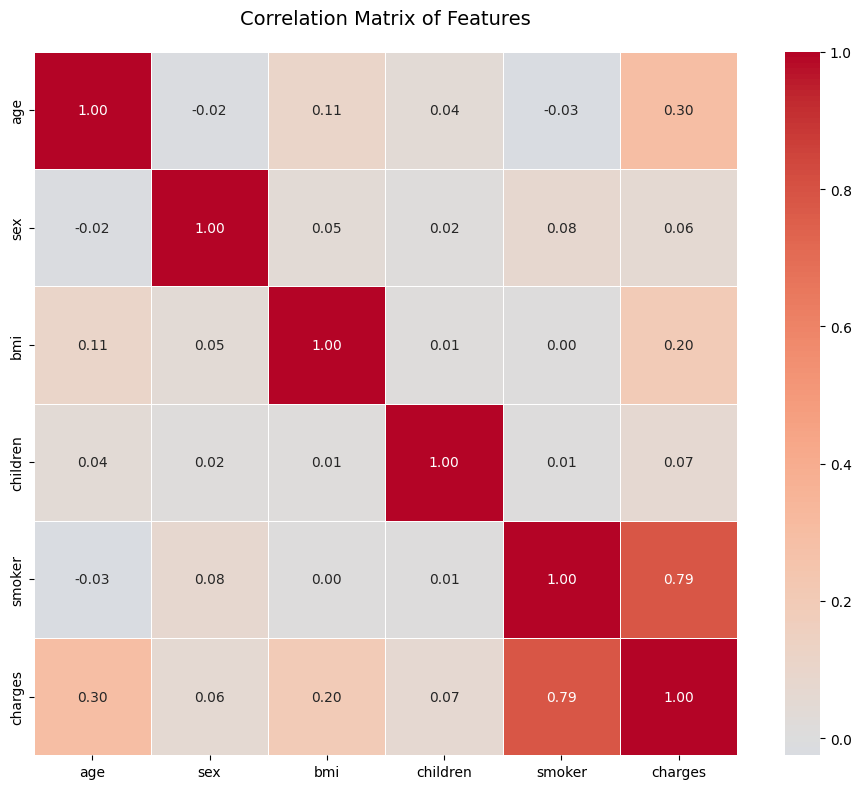

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=14, pad=20)
plt.tight_layout()

# Save the plot
output_path = Path('../python/outputs/correlation_matrix.png')
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [12]:
import sys
import numpy as np
import pandas as pd
sys.path.append('./scripts')

from gibbs_sampling import gibbs_lm, beta_trace_plot, sigma2_trace_plot
from convergence_detection import acf_plot_beta, ess_beta_table
from posterior_inference import posterior_predictive, ppc_plot

# Load cleaned data
df_cleaned = pd.read_csv('../data/expenses_cleaned.csv')
X = df_cleaned.drop('charges', axis=1).values.astype(np.float64)
y = df_cleaned['charges'].values.astype(np.float64)

# Add intercept column
X_with_intercept = np.column_stack([np.ones(X.shape[0]), X]).astype(np.float64)

In [13]:
# Run Gibbs sampler with multiple chains
# Set up priors for Gibbs sampler
p_with_intercept = X_with_intercept.shape[1]
b0_prior = np.zeros(p_with_intercept)
B0_prior = np.eye(p_with_intercept) * 1e-4  # Precision matrix (inverse of covariance)

results = gibbs_lm(
    y=y, 
    X=X_with_intercept,
    n_iter=10000,
    warmup=2000,
    n_chains=4,
    b0=b0_prior,
    B0=B0_prior,
    a0=0.01,
    d0=0.01,
    seed=123
)

# Extract results
beta_list = [chain['beta'] for chain in results]
sigma2_list = [chain['sigma2'] for chain in results]

Chain 1 completed. time_elapsed=0.488s
Chain 2 completed. time_elapsed=0.469s
Chain 3 completed. time_elapsed=0.643s
Chain 4 completed. time_elapsed=0.449s


In [14]:
# Prepare data for log-transformed model
df_raw = pd.read_csv('../data/expenses.csv')
df_raw['sex'] = df_raw['sex'].map({'male': 1, 'female': 0})
df_raw['smoker'] = df_raw['smoker'].map({'yes': 1, 'no': 0})
df_raw = pd.get_dummies(df_raw, columns=['region'], drop_first=True)
df_raw = df_raw.drop_duplicates()

y_log = np.log(df_raw['charges'].values)
X_log = df_raw.drop('charges', axis=1).values
scaler_log = StandardScaler()
X_log = scaler_log.fit_transform(X_log)
X_log_with_intercept = np.column_stack([np.ones(X_log.shape[0]), X_log]).astype(np.float64)

In [15]:
# Run Gibbs for log-transformed model
p_log = X_log_with_intercept.shape[1]
b0_log = np.zeros(p_log)
B0_log = np.eye(p_log) * 1e-4

results_log = gibbs_lm(
    y=y_log, 
    X=X_log_with_intercept,
    n_iter=10000,
    warmup=2000,
    n_chains=4,
    b0=b0_log,
    B0=B0_log,
    a0=0.01,
    d0=0.01,
    seed=456
)

beta_log = [chain['beta'] for chain in results_log]
sigma2_log = [chain['sigma2'] for chain in results_log]

Chain 1 completed. time_elapsed=0.517s
Chain 2 completed. time_elapsed=0.482s
Chain 3 completed. time_elapsed=0.473s
Chain 4 completed. time_elapsed=0.483s


In [16]:
# Generate trace plots for log model
beta_trace_plot(beta_log, model_name='log_transformed', plot_dir='outputs')
sigma2_trace_plot(sigma2_log, model_name='log_transformed', plot_dir='outputs')

# Generate ACF plots
acf_plot_beta(beta_log, model_name='log_transformed', lag_max=50, plot_dir='outputs')

# Calculate ESS
ess_log = ess_beta_table(beta_log, X_log_with_intercept, model_name='log_transformed', output_dir='outputs')
feature_names_log = ['Intercept'] + [col for col in df_raw.drop('charges', axis=1).columns]
ess_log['Feature'] = feature_names_log
ess_log = ess_log[['Feature', 'ESS']]

Saved: outputs/log_transformed/beta_trace_1.png
Saved: outputs/log_transformed/beta_trace_2.png
Saved: outputs/log_transformed/beta_trace_3.png
Saved: outputs/log_transformed/beta_trace_4.png
Saved: outputs/log_transformed/beta_trace_5.png
Saved: outputs/log_transformed/beta_trace_6.png
Saved: outputs/log_transformed/beta_trace_7.png
Saved: outputs/log_transformed/beta_trace_8.png
Saved: outputs/log_transformed/beta_trace_9.png
Saved: outputs/log_transformed/Sigma_trace.png
Saved: outputs/log_transformed/ACF_plots/full/acf_beta_0_full.png
Saved: outputs/log_transformed/ACF_plots/zoomed/acf_beta_0_zoomed.png
Saved: outputs/log_transformed/ACF_plots/full/acf_beta_1_full.png
Saved: outputs/log_transformed/ACF_plots/zoomed/acf_beta_1_zoomed.png
Saved: outputs/log_transformed/ACF_plots/full/acf_beta_2_full.png
Saved: outputs/log_transformed/ACF_plots/zoomed/acf_beta_2_zoomed.png
Saved: outputs/log_transformed/ACF_plots/full/acf_beta_3_full.png
Saved: outputs/log_transformed/ACF_plots/zoomed

In [17]:
# Prepare interaction model with smoker x BMI interaction
X_int = df_raw.drop('charges', axis=1).copy()
X_int.insert(0, 'smoker_x_bmi', X_int['smoker'] * X_int['bmi'])
X_int = X_int.values
scaler_int = StandardScaler()
X_int = scaler_int.fit_transform(X_int)

y_int = np.log(df_raw['charges'].values)
X_int_with_intercept = np.column_stack([np.ones(X_int.shape[0]), X_int]).astype(np.float64)

In [18]:
# Run Gibbs for interaction model
p_int = X_int_with_intercept.shape[1]
b0_int = np.zeros(p_int)
B0_int = np.eye(p_int) * 1e-4

results_int = gibbs_lm(
    y=y_int, 
    X=X_int_with_intercept,
    n_iter=10000,
    warmup=2000,
    n_chains=4,
    b0=b0_int,
    B0=B0_int,
    a0=0.01,
    d0=0.01,
    seed=789
)

beta_list_int = [chain['beta'] for chain in results_int]
sigma2_list_int = [chain['sigma2'] for chain in results_int]

# Generate diagnostics
beta_trace_plot(beta_list_int, model_name='interaction', plot_dir='outputs')
sigma2_trace_plot(sigma2_list_int, model_name='interaction', plot_dir='outputs')
acf_plot_beta(beta_list_int, model_name='interaction', lag_max=50, plot_dir='outputs')

ess_int = ess_beta_table(beta_list_int, X_int_with_intercept, model_name='interaction', output_dir='outputs')
feature_names_int = ['Intercept', 'smoker_x_bmi'] + [col for col in df_raw.drop('charges', axis=1).columns]
ess_int['Feature'] = feature_names_int
ess_int = ess_int[['Feature', 'ESS']]

Chain 1 completed. time_elapsed=0.614s
Chain 2 completed. time_elapsed=0.725s
Chain 3 completed. time_elapsed=0.492s
Chain 4 completed. time_elapsed=0.490s
Saved: outputs/interaction/beta_trace_1.png
Saved: outputs/interaction/beta_trace_2.png
Saved: outputs/interaction/beta_trace_3.png
Saved: outputs/interaction/beta_trace_4.png
Saved: outputs/interaction/beta_trace_5.png
Saved: outputs/interaction/beta_trace_6.png
Saved: outputs/interaction/beta_trace_7.png
Saved: outputs/interaction/beta_trace_8.png
Saved: outputs/interaction/beta_trace_9.png
Saved: outputs/interaction/beta_trace_10.png
Saved: outputs/interaction/Sigma_trace.png
Saved: outputs/interaction/ACF_plots/full/acf_beta_0_full.png
Saved: outputs/interaction/ACF_plots/zoomed/acf_beta_0_zoomed.png
Saved: outputs/interaction/ACF_plots/full/acf_beta_1_full.png
Saved: outputs/interaction/ACF_plots/zoomed/acf_beta_1_zoomed.png
Saved: outputs/interaction/ACF_plots/full/acf_beta_2_full.png
Saved: outputs/interaction/ACF_plots/zoome

In [20]:
# Compute posterior summary statistics with credible intervals
posterior_summary = []

# Compute posterior summary statistics with credible intervals

# Define feature names for baseline model
feature_names = ['Intercept'] + [col for col in df_cleaned.drop('charges', axis=1).columns]

# Combine beta samples from all chains
beta_all = np.vstack(beta_list)

posterior_summary = []

for j, feature in enumerate(feature_names):
    coef_samples = beta_all[:, j]
    
    posterior_summary.append({
        'Feature': feature,
        'Mean': coef_samples.mean(),
        'Median': np.median(coef_samples),
        'Std': coef_samples.std(),
        'CI_2.5%': np.percentile(coef_samples, 2.5),
        'CI_97.5%': np.percentile(coef_samples, 97.5)
    })

posterior_df = pd.DataFrame(posterior_summary)

In [21]:
# Generate posterior predictive samples
y_rep = posterior_predictive(beta_list, sigma2_list, X_with_intercept)

In [ ]:
# Generate posterior predictive check plots
ppc_plot(y, y_rep, model_name='baseline_model', plot_dir='outputs')

Generating posterior predictive check plots...
Saved: ../outputs/baseline_model/PPC/PPC_Scatter.png
✓ PPC plots saved to outputs/baseline_model/PPC/


In [22]:
# Model fit assessment using posterior predictive
y_pred_mean = y_rep.mean(axis=0)
y_pred_lower = np.percentile(y_rep, 2.5, axis=0)
y_pred_upper = np.percentile(y_rep, 97.5, axis=0)

# Calculate prediction intervals coverage
within_interval = np.sum((y >= y_pred_lower) & (y <= y_pred_upper))
coverage = within_interval / len(y) * 100

# Calculate RMSE
rmse_bayes = np.sqrt(np.mean((y - y_pred_mean)**2))


ESS (beta) saved to: outputs/baseline/ESS_tables/ESS_beta.txt
  Parameter      ESS
0    beta_0  23029.2
1    beta_1  23119.1
2    beta_2  23437.3
3    beta_3  23501.2
4    beta_4  22630.4
5    beta_5  21071.7


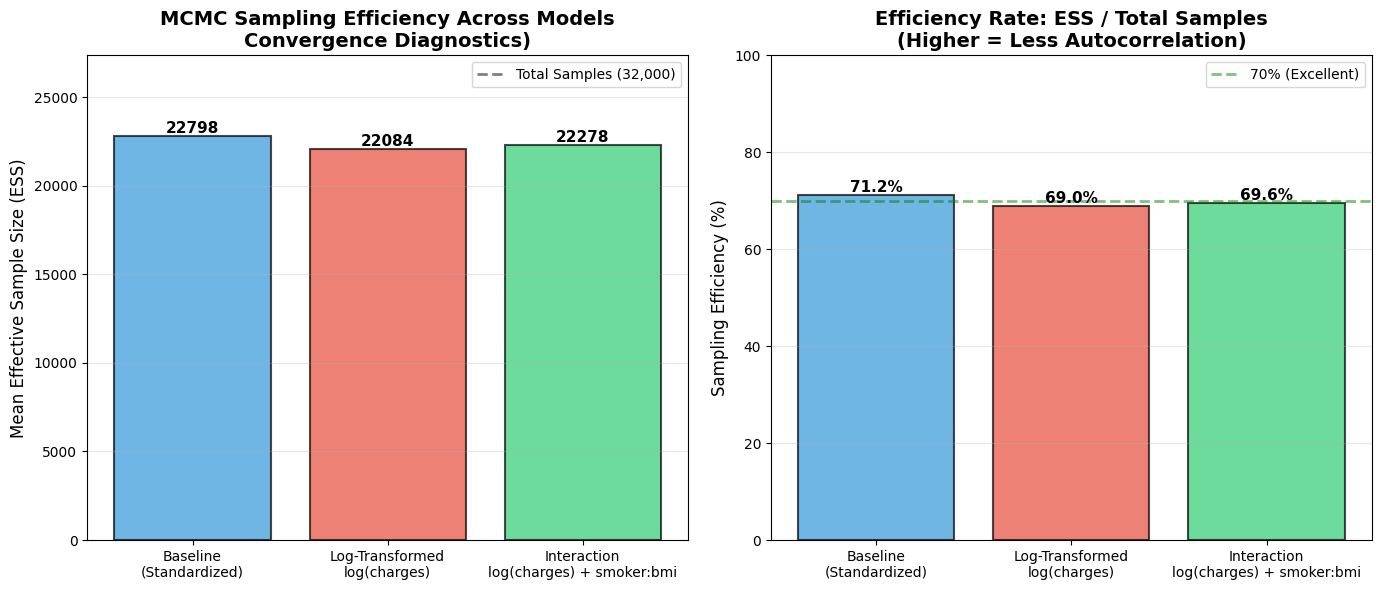

In [25]:
# Create comprehensive ESS comparison plot across all models
# Calculate ESS for baseline model (similar to log and interaction models)
from convergence_detection import ess_beta_table

ess_df = ess_beta_table(beta_list, X_with_intercept, model_name='baseline', output_dir='outputs')
ess_df['Feature'] = feature_names
ess_df = ess_df[['Feature', 'ESS']]

# Calculate mean ESS for each model
ess_baseline_mean = ess_df['ESS'].mean()
ess_log_mean = ess_log['ESS'].mean()
ess_int_mean = ess_int['ESS'].mean()

# Calculate efficiency rates (ESS / total samples)
total_samples = 32000  # 4 chains * 8000 samples
eff_baseline = (ess_baseline_mean / total_samples) * 100
eff_log = (ess_log_mean / total_samples) * 100
eff_int = (ess_int_mean / total_samples) * 100

# Create summary plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Mean ESS comparison
models = ['Baseline\n(Standardized)', 'Log-Transformed\nlog(charges)', 'Interaction\nlog(charges) + smoker:bmi']
ess_means = [ess_baseline_mean, ess_log_mean, ess_int_mean]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax1.bar(models, ess_means, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(y=total_samples, color='gray', linestyle='--', linewidth=2, label='Total Samples (32,000)')
ax1.set_ylabel('Mean Effective Sample Size (ESS)', fontsize=12)
ax1.set_title('MCMC Sampling Efficiency Across Models\nConvergence Diagnostics)', fontsize=14, fontweight='bold')
ax1.set_ylim([0, max(ess_means) * 1.2])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, ess in zip(bars, ess_means):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{ess:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Efficiency percentage
bars2 = ax2.bar(models, [eff_baseline, eff_log, eff_int], color=colors, alpha=0.7, 
                edgecolor='black', linewidth=1.5)
ax2.axhline(y=70, color='green', linestyle='--', linewidth=2, alpha=0.5, label='70% (Excellent)')
ax2.set_ylabel('Sampling Efficiency (%)', fontsize=12)
ax2.set_title('Efficiency Rate: ESS / Total Samples\n(Higher = Less Autocorrelation)', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 100])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for bar, eff in zip(bars2, [eff_baseline, eff_log, eff_int]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{eff:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(Path('../python') / 'outputs' / 'ess_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
from metropolis_hastings import metropolis_hastings_lm, adaptive_mh_lm, mh_trace_plot
import time

# Run adaptive MH (automatically tunes proposal during warmup)
mh_results = adaptive_mh_lm(
    y=y,
    X=X_with_intercept,
    n_iter=10000,
    warmup=2000,
    n_chains=4,
    b0=b0_prior,
    B0=B0_prior,
    a0=0.01,
    d0=0.01,
    initial_proposal_sd_beta=0.1,
    initial_proposal_sd_sigma2=0.1,
    target_accept=0.234,  # Optimal for high-dimensional RWM
    adapt_interval=50,
    seed=456  # Different seed from Gibbs for independence
)

# Extract results
mh_beta_list = [chain['beta'] for chain in mh_results]
mh_sigma2_list = [chain['sigma2'] for chain in mh_results]

Chain 1 (adaptive): beta_accept=0.269, sigma2_accept=0.304, time=0.68s
Chain 2 (adaptive): beta_accept=0.267, sigma2_accept=0.262, time=0.72s
Chain 3 (adaptive): beta_accept=0.207, sigma2_accept=0.222, time=0.64s
Chain 4 (adaptive): beta_accept=0.274, sigma2_accept=0.259, time=0.63s


In [30]:
# Generate trace plots for MH
mh_trace_plot(mh_beta_list, model_name='mh_baseline', plot_dir='outputs')

# Generate ACF plots for MH
acf_plot_beta(mh_beta_list, model_name='mh_baseline', lag_max=50, plot_dir='outputs')

Saved: outputs/mh_baseline/ACF_plots/full/acf_beta_0_full.png
Saved: outputs/mh_baseline/ACF_plots/zoomed/acf_beta_0_zoomed.png
Saved: outputs/mh_baseline/ACF_plots/full/acf_beta_1_full.png
Saved: outputs/mh_baseline/ACF_plots/zoomed/acf_beta_1_zoomed.png
Saved: outputs/mh_baseline/ACF_plots/full/acf_beta_2_full.png
Saved: outputs/mh_baseline/ACF_plots/zoomed/acf_beta_2_zoomed.png
Saved: outputs/mh_baseline/ACF_plots/full/acf_beta_3_full.png
Saved: outputs/mh_baseline/ACF_plots/zoomed/acf_beta_3_zoomed.png
Saved: outputs/mh_baseline/ACF_plots/full/acf_beta_4_full.png
Saved: outputs/mh_baseline/ACF_plots/zoomed/acf_beta_4_zoomed.png
Saved: outputs/mh_baseline/ACF_plots/full/acf_beta_5_full.png
Saved: outputs/mh_baseline/ACF_plots/zoomed/acf_beta_5_zoomed.png


In [31]:
# Calculate ESS for MH
ess_mh = ess_beta_table(mh_beta_list, X_with_intercept, model_name='mh_baseline', output_dir='outputs')
ess_mh['Feature'] = feature_names
ess_mh = ess_mh[['Feature', 'ESS']]

# Calculate ESS for Gibbs (same data)
ess_gibbs = ess_beta_table(beta_list, X_with_intercept, model_name='gibbs_baseline_comparison', output_dir='outputs')
ess_gibbs['Feature'] = feature_names
ess_gibbs = ess_gibbs[['Feature', 'ESS']]

# Create comparison dataframe
comparison_ess = pd.DataFrame({
    'Feature': feature_names,
    'Gibbs_ESS': ess_gibbs['ESS'].values,
    'MH_ESS': ess_mh['ESS'].values
})
comparison_ess['Gibbs_Efficiency'] = (comparison_ess['Gibbs_ESS'] / 32000) * 100
comparison_ess['MH_Efficiency'] = (comparison_ess['MH_ESS'] / 32000) * 100
comparison_ess['ESS_Ratio'] = comparison_ess['Gibbs_ESS'] / comparison_ess['MH_ESS']


ESS (beta) saved to: outputs/mh_baseline/ESS_tables/ESS_beta.txt
  Parameter     ESS
0    beta_0   594.3
1    beta_1  1995.6
2    beta_2   555.8
3    beta_3  1920.6
4    beta_4  1902.0
5    beta_5   397.0

ESS (beta) saved to: outputs/gibbs_baseline_comparison/ESS_tables/ESS_beta.txt
  Parameter      ESS
0    beta_0  23029.2
1    beta_1  23119.1
2    beta_2  23437.3
3    beta_3  23501.2
4    beta_4  22630.4
5    beta_5  21071.7


In [ ]:
# Create comprehensive algorithm comparison visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# Plot 1: ESS Comparison Bar Chart
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(feature_names))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_ess['Gibbs_ESS'], width, label='Gibbs Sampler', 
                alpha=0.8, color='#3498db', edgecolor='black', linewidth=1)
bars2 = ax1.bar(x + width/2, comparison_ess['MH_ESS'], width, label='Metropolis-Hastings', 
                alpha=0.8, color='#e74c3c', edgecolor='black', linewidth=1)

ax1.set_ylabel('Effective Sample Size (ESS)', fontsize=13, fontweight='bold')
ax1.set_title('Algorithm Comparison: Effective Sample Size by Parameter\n(Total Samples = 32,000)', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(feature_names, rotation=45, ha='right')
ax1.legend(fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=32000, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='Total Samples')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Plot 2: Efficiency Percentage Comparison
ax2 = fig.add_subplot(gs[1, 0])
mean_eff_gibbs = comparison_ess['Gibbs_Efficiency'].mean()
mean_eff_mh = comparison_ess['MH_Efficiency'].mean()

bars = ax2.bar(['Gibbs Sampler', 'Metropolis-Hastings'], 
               [mean_eff_gibbs, mean_eff_mh],
               color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=70, color='green', linestyle='--', linewidth=2, alpha=0.5, label='70% (Excellent)')
ax2.set_ylabel('Mean Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Overall Sampling Efficiency\n(ESS / Total Samples)', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 100])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bar, eff in zip(bars, [mean_eff_gibbs, mean_eff_mh]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{eff:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 3: ESS Ratio (Gibbs / MH)
ax3 = fig.add_subplot(gs[1, 1])
bars3 = ax3.barh(feature_names, comparison_ess['ESS_Ratio'], 
                 color=['#2ecc71' if r > 1 else '#e67e22' for r in comparison_ess['ESS_Ratio']],
                 alpha=0.8, edgecolor='black', linewidth=1)
ax3.axvline(x=1, color='black', linestyle='-', linewidth=2, label='Equal Performance')
ax3.set_xlabel('ESS Ratio (Gibbs / MH)', fontsize=12, fontweight='bold')
ax3.set_title('Relative Efficiency: Gibbs vs MH\n(>1 = Gibbs Better, <1 = MH Better)', 
              fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

for i, (bar, ratio) in enumerate(zip(bars3, comparison_ess['ESS_Ratio'])):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f' {ratio:.2f}x', ha='left' if width > 1 else 'right', va='center', 
             fontsize=9, fontweight='bold')

# Plot 4: Acceptance Rates (MH only)
ax4 = fig.add_subplot(gs[2, :])
chains = [f'Chain {i+1}' for i in range(len(mh_results))]
acceptance_beta = [chain['acceptance_rate_beta'] * 100 for chain in mh_results]
acceptance_sigma2 = [chain['acceptance_rate_sigma2'] * 100 for chain in mh_results]

x_chains = np.arange(len(chains))
width = 0.35

bars4a = ax4.bar(x_chains - width/2, acceptance_beta, width, label='β (coefficients)', 
                 alpha=0.8, color='#9b59b6', edgecolor='black', linewidth=1)
bars4b = ax4.bar(x_chains + width/2, acceptance_sigma2, width, label='σ² (variance)', 
                 alpha=0.8, color='#f39c12', edgecolor='black', linewidth=1)

ax4.axhline(y=23.4, color='green', linestyle='--', linewidth=2, alpha=0.7, 
            label='Optimal (23.4% for high-dim)')
ax4.set_ylabel('Acceptance Rate (%)', fontsize=12, fontweight='bold')
ax4.set_title('Metropolis-Hastings: Acceptance Rates by Chain\n(With Adaptive Tuning During Warmup)', 
              fontsize=13, fontweight='bold')
ax4.set_xticks(x_chains)
ax4.set_xticklabels(chains)
ax4.set_ylim([0, 100])
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3)

for bar in bars4a:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars4b:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.suptitle('Gibbs Sampler vs Metropolis-Hastings: Comprehensive Algorithm Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

output_path = Path('outputs') / 'algorithm_comparison' / 'algorithm_comparison_comprehensive.png'
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Model 1: Baseline (currently loaded)
# Combine chains
beta_baseline = np.vstack(beta_list)
sigma2_baseline = np.hstack(sigma2_list)

# Generate residual diagnostics
diag_baseline = create_residual_diagnostic_plot(
    y_obs=y,
    X=X_with_intercept,
    beta_samples=beta_baseline,
    sigma2_samples=sigma2_baseline,
    model_name='baseline_model',
    output_dir='outputs'
)

In [ ]:
# Model 2: Log-Transformed
# Transform response (ensure all values are positive)
y_log = np.log(y.clip(min=1e-10))  # Clip to avoid log(0)

results_log = gibbs_lm(
    y=y_log,
    X=X_with_intercept,
    n_iter=10000,
    warmup=2000,
    n_chains=4,
    b0=b0_prior,
    B0=B0_prior,
    a0=0.01,
    d0=0.01,
    seed=124
)

beta_list_log = [chain['beta'] for chain in results_log]
sigma2_list_log = [chain['sigma2'] for chain in results_log]

# Combine chains
beta_log = np.vstack(beta_list_log)
sigma2_log = np.hstack(sigma2_list_log)

# Generate residual diagnostics
diag_log = create_residual_diagnostic_plot(
    y_obs=y_log,
    X=X_with_intercept,
    beta_samples=beta_log,
    sigma2_samples=sigma2_log,
    model_name='log_transformed',
    output_dir='outputs'
)

In [ ]:
# Model 3: Interaction (smoker × BMI)
# Create interaction term - use the existing X matrix with the interaction added
smoker_col = df_cleaned['smoker'].values
bmi_col = df_cleaned['bmi'].values
smoker_bmi_interaction = (smoker_col * bmi_col).reshape(-1, 1)

# Add interaction term to existing design matrix
X_interaction_full = np.column_stack([X_with_intercept, smoker_bmi_interaction])

# Set up priors
p_interaction = X_interaction_full.shape[1]
b0_interaction = np.zeros(p_interaction)
B0_interaction = np.eye(p_interaction) * 1e-4

results_interaction = gibbs_lm(
    y=y_log,  # Still use log-transformed response
    X=X_interaction_full,
    n_iter=10000,
    warmup=2000,
    n_chains=4,
    b0=b0_interaction,
    B0=B0_interaction,
    a0=0.01,
    d0=0.01,
    seed=125
)

beta_list_interaction = [chain['beta'] for chain in results_interaction]
sigma2_list_interaction = [chain['sigma2'] for chain in results_interaction]

# Combine chains
beta_interaction = np.vstack(beta_list_interaction)
sigma2_interaction = np.hstack(sigma2_list_interaction)

# Generate residual diagnostics
diag_interaction = create_residual_diagnostic_plot(
    y_obs=y_log,
    X=X_interaction_full,
    beta_samples=beta_interaction,
    sigma2_samples=sigma2_interaction,
    model_name='interaction',
    output_dir='outputs'
)

In [ ]:
# Create comparison plot across all three models
diagnostics_dict = {
    'Baseline': diag_baseline,
    'Log-Transformed': diag_log,
    'Interaction': diag_interaction
}

create_residual_comparison_plot(diagnostics_dict, output_dir='outputs')